# Lego Block Image Classification

# 1. Data Preprocessing and Visualization

In [1]:
#helper library
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
#import os.path

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop

from skimage.transform import resize

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [2]:
# Create a list with the filepaths for training
def get_path(my_path):    
    #dir_ = Path('../ML/Lego/processed_data/train/')
    dir_ = Path(my_path)
    file_paths = list(dir_.glob(r'**/*.png'))
    file_paths = [str(x) for x in file_paths]
    df = pd.DataFrame({'Filepath':file_paths})
    return df

train_df = get_path('../ML/Lego/processed_data/train/')

train_df.Filepath[0]

'..\\ML\\Lego\\processed_data\\train\\11214 Bush 3M friction with Cross axle\\201706171006-0001.png'

In [3]:
def get_label(string):
    string  = ' '.join(string.split('/')[-1].replace('.png', '').split(' ')[1:])
    string = string.split('\\')[0]
    string = string.lower()
    return string

# Retrieve the label from the path of the pictures
train_df['Label'] = train_df['Filepath'].apply(lambda x: get_label(x))

train_df.head()

,Filepath,Label
0,..\ML\Lego\processed_data\train\11214 Bush 3M ...,bush 3m friction with cross axle
1,..\ML\Lego\processed_data\train\11214 Bush 3M ...,bush 3m friction with cross axle
2,..\ML\Lego\processed_data\train\11214 Bush 3M ...,bush 3m friction with cross axle
3,..\ML\Lego\processed_data\train\11214 Bush 3M ...,bush 3m friction with cross axle
4,..\ML\Lego\processed_data\train\11214 Bush 3M ...,bush 3m friction with cross axle


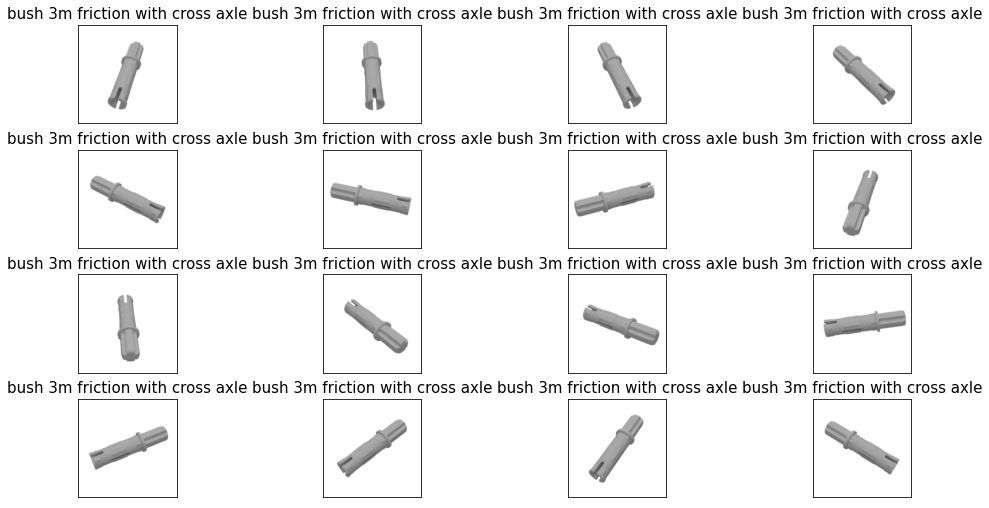

In [4]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(train_df.Filepath[i]))
    ax.set_title(train_df.Label[i], fontsize = 15)
plt.tight_layout(pad=0.5)
plt.show()

In [5]:
cv2.imread(train_df.Filepath[0]).shape

(200, 200, 3)

In [6]:
test_df = get_path('../ML/Lego/processed_data/test/')

# Retrieve the label from the path of the pictures
test_df['Label'] = test_df['Filepath'].apply(lambda x: get_label(x))

test_df.head()

,Filepath,Label
0,..\ML\Lego\processed_data\test\11214 Bush 3M f...,bush 3m friction with cross axle
1,..\ML\Lego\processed_data\test\11214 Bush 3M f...,bush 3m friction with cross axle
2,..\ML\Lego\processed_data\test\11214 Bush 3M f...,bush 3m friction with cross axle
3,..\ML\Lego\processed_data\test\11214 Bush 3M f...,bush 3m friction with cross axle
4,..\ML\Lego\processed_data\test\11214 Bush 3M f...,bush 3m friction with cross axle


In [7]:
val_df = get_path('../ML/Lego/processed_data/val/')

# Retrieve the label from the path of the pictures
val_df['Label'] = val_df['Filepath'].apply(lambda x: get_label(x))

val_df.head()

,Filepath,Label
0,..\ML\Lego\processed_data\val\11214 Bush 3M fr...,bush 3m friction with cross axle
1,..\ML\Lego\processed_data\val\11214 Bush 3M fr...,bush 3m friction with cross axle
2,..\ML\Lego\processed_data\val\11214 Bush 3M fr...,bush 3m friction with cross axle
3,..\ML\Lego\processed_data\val\11214 Bush 3M fr...,bush 3m friction with cross axle
4,..\ML\Lego\processed_data\val\11214 Bush 3M fr...,bush 3m friction with cross axle


In [8]:
vc_train = train_df['Label'].value_counts()
print(vc_train)

technic lever 3m                    240
plate 2x2                           240
plate 1x2                           240
flat tile 1x2                       240
peg 2m                              240
brick 2x2                           240
bush for cross axle                 240
plate 1x2 with 1 knob               240
cross axle 2m with snap friction    240
plate 1x1                           240
brick 1x1                           240
half bush                           240
roof tile 1x2x45deg                 240
bush 3m friction with cross axle    240
brick 1x2                           240
brick corner 1x2x2                  227
Name: Label, dtype: int64


In [ ]:
vc_train = train_df['Label'].value_counts()
vc_test = test_df['Label'].value_counts()

plt.figure(figsize=(20,5))
sns.barplot(x = sorted(vc_train.index), y = vc_train, label = "Training Data", color='darkblue')
sns.barplot(x = sorted(vc_test.index), y = vc_test, bottom = vc_train, label = "Testing Data", color='lightblue')

plt.xlabel("Label")
plt.ylabel("Total")
plt.title("Number of sample by training group and testing group")
plt.legend()
plt.show()

# 2. Generate training and validation dataset

In [ ]:
def resize_pad(img):
    old_size = img.shape[:2]
    ratio = 200. / max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    img = resize(img, output_shape=new_size, mode='edge', preserve_range=True)
    
    delta_w = 200 - new_size[1]
    delta_h = 200 - new_size[0]
    padding = ((delta_h//2, delta_h-(delta_h//2)), (delta_w//2, delta_w-(delta_w//2)), (0, 0))
    
    img = np.pad(img, padding, 'edge')
    
    return img

def preprocessing_train(x):
    x = resize_pad(x)
    return x

def preprocessing_test(x):
    x = resize_pad(x)
    return x

train_generator = ImageDataGenerator(
                        preprocessing_function=preprocessing_train,
                        rescale = 1/255,
                        zoom_range=0.05,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        horizontal_flip=True,
                        vertical_flip=True,
                        rotation_range=90,
                        validation_split=0.1)

test_generator = ImageDataGenerator(
                        preprocessing_function=preprocessing_test,
                        rescale = 1/255)

In [ ]:
train_dataset = train_generator.flow_from_dataframe(dataframe=train_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          color_mode='rgb',
                                          target_size = (200,200),
                                          batch_size = 32,
                                          class_mode = 'categorical',
                                          #subset='training',
                                          seed=0)

In [ ]:
validation_dataset = train_generator.flow_from_dataframe(dataframe=val_df,
                                          x_col='Filepath',
                                          y_col='Label',
                                          color_mode='rgb',
                                          target_size = (200,200),
                                          batch_size = 32,
                                          class_mode = 'categorical',
                                          #subset='validation',
                                          seed=0)

In [ ]:
test_dataset = test_generator.flow_from_dataframe(dataframe = test_df,
                                        x_col='Filepath',
                                        y_col='Label',
                                        color_mode='rgb',
                                        target_size = (200,200),
                                        batch_size = 32,
                                        class_mode = 'categorical',
                                        shuffle = False,
                                        seed=0)

In [ ]:
#classes
train_dataset.class_indices

In [ ]:
train_dataset.classes

# 3. Build Model

Set up layers

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,kernel_size=3, activation = 'relu', padding = 'same', input_shape = (200,200,3)),
    tf.keras.layers.MaxPool2D(),
    #
    tf.keras.layers.Conv2D(32,kernel_size=3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    #
    tf.keras.layers.Conv2D(64,kernel_size=3, padding = 'same', activation = 'relu'),
    tf.keras.layers.MaxPool2D(),
    #
    tf.keras.layers.Flatten(),
    ##
    tf.keras.layers.Dense(512, activation = 'relu'),
    ##
    tf.keras.layers.Dense(128, activation = 'relu'),
    ##
    tf.keras.layers.Dense(16, activation='softmax')
    ])

model.summary()

In [ ]:
model.compile(loss= 'categorical_crossentropy',
              optimizer='adam',
             metrics = ['accuracy'])

In [ ]:
model_fit = model.fit(train_dataset, epochs = 20, validation_data = validation_dataset)

# 4. Make Predictions

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(model_fit.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(model_fit.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_dataset)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_dataset.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Get the accuracy on the test set
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)

# Display the results
printmd(f'## Model with {acc*100:.2f}% accuracy on the test set') #: {best_model[0]}

# 5. Verify Prediction

In [ ]:
# Display a confusion matrix
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=90)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Display picture of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 15)
plt.tight_layout()
plt.show()

In [ ]:
pred_df = pd.DataFrame({'Prediction':pred})
test_df = test_df.join(pred_df['Prediction'])
test_df.head()

test_df.to_csv("result.csv",header=True,index=False)